In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt
import importlib

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Sun Mar 19 17:19:45 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.23.2
    qiskit-aer : 0.12.0
    qiskit-ignis : None
    qiskit-ibmq-provider : 0.20.2
    qiskit : 0.42.0
    qiskit-nature : 0.5.2
    qiskit-finance : None
    qiskit-optimization : None
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Options,
                                Estimator as RuntimeEstimator)

from qiskit.providers.fake_provider import FakeGuadalupe


providerV0 = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        compatible=True,
                                        output=True,   # Print out the available backends
                                       )
###### ibm Version Compatible backends ##########################
# 5 qubit H/W

belemV0            = providerV0.get_backend('ibmq_belem')
limaV0             = providerV0.get_backend('ibmq_lima')
manilaV0           = providerV0.get_backend('ibmq_manila')
quitoV0            = providerV0.get_backend('ibmq_quito')
# 7 qubit H/W
nairobiV0          = providerV0.get_backend('ibm_nairobi')
osloV0             = providerV0.get_backend('ibm_oslo')
jakartaV0          = providerV0.get_backend('ibmq_jakarta')
perthV0            = providerV0.get_backend('ibm_perth')
lagosV0            = providerV0.get_backend('ibm_lagos')
backendsV0 = {'5':belemV0,  '7':osloV0, '16':FakeGuadalupe(),
              'm':manilaV0, 'q':quitoV0, 'a':limaV0, 'b':belemV0,
              'j':jakartaV0,'o':osloV0,  'l':lagosV0,
              'n':nairobiV0,'p':perthV0,            
              'g':FakeGuadalupe(),}


#################### Runtime API Backends ###################################
provider,service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        compatible=False,
                                        output=True,   # Print out the available backends
                                       )
backends_runtime = {'5':'ibmq_belem',  '7':'oslo',
                    'm':'ibmq_manila', 'q':'ibmq_quito', 'a':'ibmq_lima', 'b':'ibmq_belem',
                    'j':'ibmq_jakarta','o':'ibm_oslo',  'l':'ibm_lagos',
                    'n':'ibm_nairobi','p':'ibm_perth',            
                    'g':FakeGuadalupe(),}
# 5 qubit H/W
belem            = provider.get_backend('ibmq_belem')
lima             = provider.get_backend('ibmq_lima')
manila           = provider.get_backend('ibmq_manila')
quito            = provider.get_backend('ibmq_quito')
# 7 qubit H/W
nairobi          = provider.get_backend('ibm_nairobi')
oslo             = provider.get_backend('ibm_oslo')
jakarta          = provider.get_backend('ibmq_jakarta')
perth            = provider.get_backend('ibm_perth')
lagos            = provider.get_backend('ibm_lagos')

backends = {'5':belem,  '7':oslo, '16':FakeGuadalupe(),
            'm':manila, 'q':quito, 'a':lima, 'b':belem,
            'j':jakarta,'o':oslo,  'l':lagos,
            'n':nairobi,'p':perth,            
            'g':FakeGuadalupe(),}

from qiskit_aer import AerSimulator, StatevectorSimulator
max_parallel=24

svectorSim   = StatevectorSimulator(max_parallel_experiments=max_parallel)
# 5qubit
belemSim     = AerSimulator(max_parallel_experiments=max_parallel).from_backend(belem)
limaSim      = AerSimulator(max_parallel_experiments=max_parallel).from_backend(lima)
quitoSim     = AerSimulator(max_parallel_experiments=max_parallel).from_backend(quito)
manilaSim    = AerSimulator(max_parallel_experiments=max_parallel).from_backend(manila)

# 7 qubit
nairobiSim   = AerSimulator(max_parallel_experiments=max_parallel).from_backend(nairobi)
osloSim      = AerSimulator(max_parallel_experiments=max_parallel).from_backend(oslo)
jakartaSim   = AerSimulator(max_parallel_experiments=max_parallel).from_backend(jakarta)
perthSim     = AerSimulator(max_parallel_experiments=max_parallel).from_backend(perth)
lagosSim     = AerSimulator(max_parallel_experiments=max_parallel).from_backend(lagos)
# 16 qubit
guadalupeSim = AerSimulator(max_parallel_experiments=max_parallel).from_backend(FakeGuadalupe())

simulators = {'m':manilaSim,    'q':quitoSim, 'a':limaSim, 'b':belemSim,
              'j':jakartaSim,   'o':oslo,     'l':lagosSim,
              'n':nairobiSim,   'p':perthSim,            
              'g':FakeGuadalupe(),
             }
print(f"Hardware Setup Complete")

Available backends
	ibmq_qasm_simulator
	ibmq_lima
	ibmq_belem
	ibmq_quito
	simulator_statevector
	simulator_mps
	simulator_extended_stabilizer
	simulator_stabilizer
	ibmq_jakarta
	ibmq_manila
	ibm_lagos
	ibm_nairobi
	ibm_perth
	ibm_oslo
Available backends
	simulator_stabilizer
	ibm_lagos
	ibmq_belem
	ibm_oslo
	simulator_extended_stabilizer
	ibm_perth
	ibmq_jakarta
	simulator_statevector
	ibmq_quito
	ibmq_lima
	simulator_mps
	ibmq_manila
	ibm_nairobi
	ibmq_qasm_simulator
Hardware Setup Complete


# Hamiltonians and Ansatze

In [3]:
import hamiltonians, ansatze
from qiskit import transpile
# Anzs  = ansatze.init_ansatze(H=hams,backends=backends,targets=targets)
def stack_couplings(Anzs=None, Adevices=None, couplings=None,
                    backends=None, devices=['a'],
                    nNodes=3, nQubits=5, qbitmap=[0,1,2,], ):
    Anzs = {} if Anzs is None else Anzs
    Adevices = {} if Adevices is None else Adevices
    
    #################################### Loop through Entanglements, Reps, and Devices
    for E, coupling in couplings.items():
        Anzs[f'A{nNodes}_{nNodes}_{E}_L1'] = baseQC = ansatze.customAnsatz4(nNodes, 
                                            qc=None,  
                                            name=f'A{nNodes}_{nNodes}_{E}_L1', 
                                            couplings=coupling )
        Anzs[f'A{nNodes}_{nQubits}_{E}_L1'] = ansatze.customAnsatz4(nQubits, qc=None,
                                            name=f'A{nNodes}_{nQubits}_{E}_L1', couplings=coupling )
        for D in devices:
            Anzs[f'A{nNodes}_{D}_{E}_L1'] = transpile(baseQC, backend=backends[D], initial_layout=qbitmap)
            Adevices[f'A{nNodes}_{D}_{E}_L1'] = D
    ####################################

    for key in Anzs.keys():
        Anzs[key].name = key
    return Anzs, Adevices    
    

def local_ansatze(Anzs=None, Adevices=None,
                  couplings={'SA1':[[0,1],[1,2],[1,3],],},
                  reps=[2,1,],
                  backends=None, devices=['a'],
                  nNodes=3,nQubits=5,qbitmap=[0,1,2,], ):
    Anzs = {} if Anzs is None else Anzs
    Adevices = {} if Adevices is None else Adevices
    
    #################################### Loop through Entanglements, Reps, and Devices
    for E, coupling in couplings.items():
        for R in reps:
            Anzs[f'A{nNodes}_{nNodes}_{E}_L{R}'] = baseQC = ansatze.customAnsatz3(nNodes, 
                                                qc=None, reps= R, 
                                                name=f'A{nNodes}_{nNodes}_{E}_L{R}', 
                                                coupling=coupling )
            Anzs[f'A{nNodes}_{nQubits}_{E}_L{R}'] = ansatze.customAnsatz3(nQubits, qc=None, reps= R, 
                                                name=f'A{nNodes}_{nQubits}_{E}_L{R}', coupling=coupling )
            for D in devices:
                Anzs[f'A{nNodes}_{D}_{E}_L{R}'] = transpile(baseQC, backend=backends[D], initial_layout=qbitmap)
                Adevices[f'A{nNodes}_{D}_{E}_L{R}'] = D
    ####################################

    for key in Anzs.keys():
        Anzs[key].name = key
    return Anzs, Adevices

In [4]:
import kagome, hamiltonians, ansatze
optimizers=kagome.init_optimizers()  #=================== Optimizers =========================#
cells = hamiltonians.init_cells()    #===================  Cell Structures ===================# 
positions = hamiltonians.init_positions()

#====================  Hamiltonians =====================#
hams,eigenvalue_results,targets = hamiltonians.init_hamiltonians(cells=cells,force=False, k=128, display=3)
print(f"Hamiltonians Loaded")
    
#=======================  Ansatze =======================#
# Anzs = ansatze.init_ansatze(H=hams,backends=backends,targets=targets)
# Anzs,AnzsDevices=local_ansatze()
# ansatze.list_Ansatz(Anzs)


H12_16: Edges 18 Eigenvalues 128 
	-18.0000:[32]
	-16.9613:[38]
	-16.9449:[37]

H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]

H3_5: Edges 3 Eigenvalues 32 
	 -3.0000:[16]
	  3.0000:[16]

H3_7: Edges 3 Eigenvalues 128 
	 -3.0000:[64]
	  3.0000:[64]

Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]

Hsq_5: Edges 4 Eigenvalues 32 
	 -8.0000:[2]
	 -4.0000:[6]
	 -0.0000:[14]

Hsq_m: Edges 4 Eigenvalues 32 
	 -8.0000:[2]
	 -4.0000:[6]
	 -0.0000:[14]

Hsq_7: Edges 4 Eigenvalues 128 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[56]

H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]

H4_5: Edges 4 Eigenvalues 32 
	 -6.0000:[2]
	 -4.0000:[6]
	 -2.0000:[8]

H4_7: Edges 4 Eigenvalues 128 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]

H4_12: Edges 4 Eigenvalues 128 
	 -6.0000:[83]
	 -4.0000:[45]

H5_5: Edges 6 Eigenvalues 32 
	 -6.0000:[6]
	 -4.0000:[4]
	 -2.0000:[2]

H5_7: Edges 6 Eigenvalues 128 
	 -6.0000:[24]
	 -4.0000:[16]
	 -2.0000:[8]

H5_

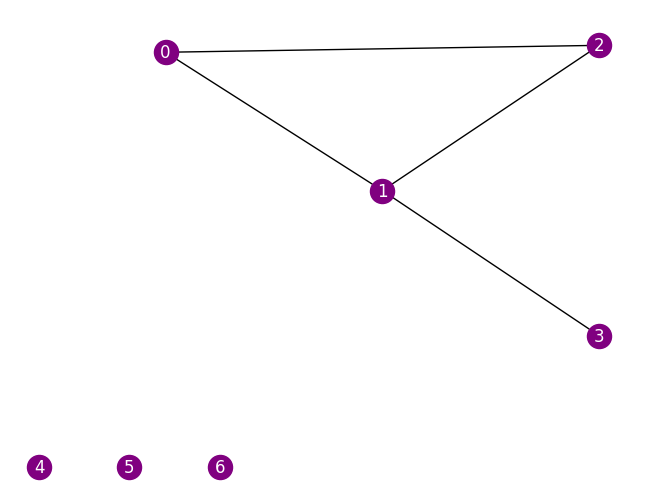

In [5]:
key='4_7'
_=kagome.draw_lattice(cells[key],positions[key])

In [6]:
from importlib import reload
import jTools
jTools.cellOutputAll()

In [7]:
def runJob(Hkey=None,Akey=None,miniAkey=None,nshots=1024,optimization=3,resilience=1,
           pt_idx='Random',backend=None, Okey=None, numRuns=-1, service=None, x0=None, fname=None,
           forced_xdata = None,
           job_tags=['runJob']):
    from qiskit_aer.backends.aerbackend import AerBackend, AerError
    from qiskit_ibm_runtime import Options
    if backend is None or isinstance(backend,AerBackend):
        service = None
        options = { 'shots': nshots }
    else:
        service = service
        options = Options(optimization_level = optimization, 
                          resilience_level  = resilience,
                          execution = {'shots':nshots}, 
                          environment = {'job_tags':job_tags},
                         )   

    #==================== Job Control ======================
    label = (f"{backend}['shots':{nshots} 'Optimize':{optimization} 'Resilience':{resilience}]\n"
             f"H:{Hkey} A:{Anzs[Akey].name}\nOpt:{optimizers[Okey]['label']} x0={pt_idx}")
    if numRuns > 0:
        curCache = kagome.load_results(fname)
        for i in range(numRuns):
            print(f"{kagome.strtime()} : Starting Run {i}")
            custom_vqe = kagome.run_kagomeVQE(hams[Hkey], Anzs[Akey], optimizers[Okey]['opt'], 
                                         miniAnsatz=Anzs[miniAkey],
                                         timeout=None, x0=x0, 
                                         target=np.around(targets[Hkey],6),
                                         service=service, backend=backend,
                                         resultsList=curCache, 
                                         label=label, options=options,
                                         forced_xdata=forced_xdata,)
            kagome.save_results(curCache,fname)
        return curCache
    else:
        print(label)
        
        
def runConfig(orgConfig,updates=None,plot=False,global_seed=None, np_seed=None):
    from qiskit.utils import algorithm_globals
    updates = {} if updates is None else updates
    finalConfig = {key: updates.get(key, orgConfig[key]) for key in orgConfig}
    if np_seed is not None:
        np.random.seed(np_seed)
    if global_seed is not None:
        algorithm_globals.random_seed = global_seed   # For SPSA stochastic repeatability
    curCache = runJob(**finalConfig)
    if plot and finalConfig.get('forced_xdata',None) is None:
        kagome.plot_SPSA_convergence(curCache,indices=[-1],conv_lim = 0.03,movingAvg=5,
                                     perc=6,convergence=False,minStart=20)
    return curCache


In [8]:
def compare_forcedX(indices,label_dict=None,labels=['0','1'],title=None,fdata=[],xdata=[]):
    xdiffNorms,fdiffNorms =[],[]
    
    labels=[label_dict[indices[0]],label_dict[indices[1]]] if label_dict is not None else labels
    title=f"{labels[0]}({labels[1]})" if title is None else title
    colors=['red','green']
    
    for idx in indices:
        fdata.append(curCache[idx]._callback_data)
        xdata.append(curCache[idx]._callback_points)
    xdiffs = np.array(xdata[0]) -  np.array(xdata[1])

    delXnorms  = np.linalg.norm(xdiffs,axis=1)
    for curDiff in xdiffs:
        xdiffNorms.append(np.linalg.norm(curDiff))
    fdiffs = np.array(fdata[0]) -  np.array(fdata[1])
    for curDiff in fdiffs:
        fdiffNorms.append(np.linalg.norm(curDiff))

    maxdelX = np.max(delXnorms)
    if maxdelX < 0.001:
        print(f"Identical X max(delX)={maxdelX}")
    kagome.quick_plot(fdata,labels=labels,colors=colors,figsize=(8.5,6), title=title)
    kagome.quick_plot(fdiffNorms,labels=[f"Delta F(x)[{labels[0]}][{labels[1]}]"],title=f'delF {labels[0]}')

    if maxdelX >= 0.001:
        kagome.quick_plot(delXnorms,labels=['||del; X||'],title='||Norm delX||')

def compare_runs(dataCache,indices=None,labels=('Unk','Unk')):
    (idxA,idxB) = (indices[0],indices[1])
    (devA,devB) = (labels[0],labels[1])
    xdata=[ dataCache[idxA]._callback_points, dataCache[idxB]._callback_points ]
    fdata=[ dataCache[idxA]._callback_data,   dataCache[idxB]._callback_data ]
    (minA,minB) = (np.min(np.array(fdata[0])),np.min(np.array(fdata[1])))
    (minAidx,minBidx) = (np.argmin(np.array(fdata[0])),np.argmin(np.array(fdata[1])))
    print(f"Minimums\n\tFa[{minAidx}]={minA:6.4f}\n\tFb[{minBidx}]={minB:6.4f}\n")
    
    compare_forcedX([],label_dict=None,labels=[f'{devA}[{idxA}]',f'{devB}[{idxB}]'],
                    xdata=xdata,fdata=fdata, title=f'{devB}[{devA}({idxA})]') 
    kagome.plot_SPSA_convergence(dataCache,indices=[idxB],convergence=False,)


# Optimizer Options

In [9]:
reload(ansatze)
A4_7couplings = {
#                 'SA11': [[0,1],[1,2],[1,3],],
#                 'SA12': [[0,1],[0,2],[1,2],],  #TBD
#                 'SA13': [[0,2],],               # TBD
#                 'SA14': [[1,2],[1,3],[0,1],[1,0],[3,1],[2,1],],
                'SA15': [[0,1],[1,3],[1,2],[2,1],[3,1],[1,0]],  
#                 'SA16': [[1,0],[1,3],[1,2],[2,1],[1,3],[1,0]],
#                 'SA17': [[1,0],[1,3],[1,2],[3,0],[2,1],[1,3],[1,0],[0,3],],
#                 'SA18': [[1,0],[1,3],[1,2],[3,0],[2,1],[1,3],[1,0],],
#                 'SA19': [[0,1],[1,3],[1,2],[3,0],[2,1],[3,1],[1,0]],  
#                 'SA20': [[0,1],[1,3],[1,2],[0,3],[2,1],[3,1],[1,0],],
               }
A7_devices = ['j','o','p','l','n']
A7_devices = [ 'j' ]
A4_7_reps = [2,]
(nNodes,nQubits,A4_7qbitmap,) = (4,7,ansatze.qbitmap_4_to_7,)
Anzs,Adevices=ansatze.local_ansatze(nNodes=nNodes, nQubits=nQubits, qbitmap=A4_7qbitmap,
                               backends=backendsV0, qubits=[0,1,2,3,],
                               devices = A7_devices,reps=A4_7_reps, couplings=A4_7couplings, 
                               )
A4_7_stacks = {
#              'ST11': [ [ [0,1],[1,2],[1,3], ],
#                        [ [0,2], ]
#                      ],             
#              'ST12': [ [ [0,1],[1,3],[1,2],[2,1],[3,1],[1,0] ],  
#                        [ [0,2],[2,3], ]
#                      ],
             'ST13': [ [ [1,0],[1,3],[1,2],[2,1],[1,3],[1,0] ],
                       [ [0,2],[3,2]]
                     ],
#              'ST14': [ [ [1,2],[1,3],[0,1],[1,0],[3,1],[2,1], ],
#                        [ [0,2], ],
#                      ],
#              'ST15': [ [ [0,1],[1,3],[1,2],[2,1],[3,1],[1,0] ],  
#                        [ [0,2], ]
#                      ],
#              'ST16': [ [ [1,0],[1,3],[1,2],[2,1],[1,3],[1,0] ],
#                        [ [0,2], ]
#                      ],
#              'ST17': [ [ [1,0],[1,2],[1,3],[3,1],[2,1],[0,1] ],   # Linked (Out) and Down
#                        [ [0,2],[2,3],[3,0] ]                      # Unlinked a-b-c
#                      ],
#              'ST18': [ [ [1,0],[1,2],[1,3],[3,1],[2,1],[0,1] ],   # Linked UP & Down
#                        [ [1,2],[2,1],[1,2],[3,1],[3,0] ]          # Manual swap and link
#                      ],
#              'ST19': [ [ [0,2],[2,3],[3,0]  ],                    # Unlinked 
#                        [ [1,0],[1,2],[1,3],[3,1],[2,1],[0,1] ],   # Linked (Out) & Back 
#                      ],
#              'ST20': [ [ [0,1],[1,2],[1,3], ],                    # Linked UP
#                        [ [3,1],[2,1],[1,0], ],                    # Back Down
#                      ],             
#              'ST21': [ [ [1,0],[1,2],[1,3],[3,1],[2,1],[0,1] ],   # Linked (Out) and Down
#                        [ [0,2],[0,3],[2,3] ]                      # Unlinked Linear
#                      ],             
             'ST22': [ [ [1,0],[1,3],[1,2],[2,1],[1,3],[0,1] ],
                       [ [0,2], ],
                     ],

            }
Anzs,Adevices=ansatze.stack_couplings(Anzs=Anzs, Adevices=Adevices, 
                              couplings=A4_7_stacks,  qubits=[0,1,2,3],
                              backends=backendsV0, devices=['j'],
                              nNodes=nNodes, nQubits=nQubits, qbitmap=[0,1,2,3,4,5,6] )
# ansatze.list_Ansatz(Anzs)

<module 'ansatze' from '/home/richard/src/notebooks/open-science-prize-2022/ansatze.py'>

In [10]:
Types=list(A4_7couplings.keys())
AbackendsV0={}
for key, D in Adevices.items():
    AbackendsV0[key] = backendsV0[D]
qubits = A4_7qbitmap
print(f"Building Circuit Images")
Aimages=ansatze.Anzs_images( Akeys=None, Anzs=Anzs )
print(f"Building Circuit Schedules")
schedules,sched_images=ansatze.Anzs_schedules(Akeys=None, Anzs=Anzs, backends=AbackendsV0,)
print(f"\nSchedules Complete")

Building Circuit Images
Building Circuit Schedules
No Backend  A4_4_SA15_L2, A4_7_SA15_L2, A4_7_ST13_L1, A4_7_ST22_L1,
Schedules Complete


In [11]:
Anzs['A4_7_SA15_L2'].draw()
Anzs['A4_j_SA15_L2'].draw()
df = ansatze.eval_schedules(schedules, AbackendsV0,Akeys=None,qubits=[0,1,2,3])
df

┌─────────┐┌────┐┌─────────┐                            ┌───┐    »
q_0: ┤ Rz(θ_0) ├┤ √X ├┤ Rz(θ_1) ├──■─────────────────────────┤ X ├────»
     ├─────────┤├────┤├─────────┤┌─┴─┐          ┌───┐┌───┐   └─┬─┘    »
q_1: ┤ Rz(θ_2) ├┤ √X ├┤ Rz(θ_3) ├┤ X ├──■────■──┤ X ├┤ X ├─────■──────»
     ├─────────┤├────┤├─────────┤└───┘  │  ┌─┴─┐└─┬─┘└─┬─┘┌──────────┐»
q_2: ┤ Rz(θ_4) ├┤ √X ├┤ Rz(θ_5) ├───────┼──┤ X ├──■────┼──┤ Rz(θ_12) ├»
     ├─────────┤├────┤├─────────┤     ┌─┴─┐└───┘       │  ├──────────┤»
q_3: ┤ Rz(θ_6) ├┤ √X ├┤ Rz(θ_7) ├─────┤ X ├────────────■──┤ Rz(θ_14) ├»
     └─────────┘└────┘└─────────┘     └───┘               └──────────┘»
q_4: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_5: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_6: ─────────────────────────────────────────────────────────────────»
                                                                      »
«     ┌─────────┐    ┌────┐   ┌─────────┐                          ┌───┐
«q_0: ┤ Rz(θ_8) ├────┤ √X ├───┤ Rz(θ_9) ├───■──────────────────────┤ X ├
«     ├─────────┴┐   ├────┤   ├─────────┴┐┌─┴─┐          ┌───┐┌───┐└─┬─┘
«q_1: ┤ Rz(θ_10) ├───┤ √X ├───┤ Rz(θ_11) ├┤ X ├──■────■──┤ X ├┤ X ├──■──
«     └──┬────┬──┘┌──┴────┴──┐└──────────┘└───┘  │  ┌─┴─┐└─┬─┘└─┬─┘     
«q_2: ───┤ √X ├───┤ Rz(θ_13) ├───────────────────┼──┤ X ├──■────┼───────
«        ├────┤   ├──────────┤                 ┌─┴─┐└───┘       │       
«q_3: ───┤ √X ├───┤ Rz(θ_15) ├─────────────────┤ X ├────────────■───────
«        └────┘   └──────────┘                 └───┘                    
«q_4: ──────────────────────────────────────────────────────────────────
«                                                                       
«q_5: ──────────────────────────────────────────────────────────────────
«                                                                       
«q_6: ──────────────────────────────────────────────────────────────────
«

┌─────────┐┌────┐┌─────────┐                                »
      q_0 -> 0 ┤ Rz(θ_0) ├┤ √X ├┤ Rz(θ_1) ├──■─────────────────────────────»
               ├─────────┤├────┤├─────────┤┌─┴─┐          ┌───┐            »
      q_1 -> 1 ┤ Rz(θ_2) ├┤ √X ├┤ Rz(θ_3) ├┤ X ├──■────■──┤ X ├────────────»
               ├─────────┤├────┤├─────────┤└───┘  │  ┌─┴─┐└─┬─┘┌──────────┐»
      q_2 -> 2 ┤ Rz(θ_4) ├┤ √X ├┤ Rz(θ_5) ├───────┼──┤ X ├──■──┤ Rz(θ_12) ├»
               ├─────────┤├────┤├─────────┤     ┌─┴─┐└───┘     └──────────┘»
      q_3 -> 3 ┤ Rz(θ_6) ├┤ √X ├┤ Rz(θ_7) ├─────┤ X ├──────────────────────»
               └─────────┘└────┘└─────────┘     └───┘                      »
ancilla_0 -> 4 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_1 -> 5 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_2 -> 6 ────────────────────────────────────────────────────────────»
                                                                           »
«                       ┌───┐    ┌─────────┐    ┌────┐   ┌─────────┐           »
«      q_0 -> 0 ────────┤ X ├────┤ Rz(θ_8) ├────┤ √X ├───┤ Rz(θ_9) ├───■───────»
«               ┌───┐   └─┬─┘    ├─────────┴┐   ├────┤   ├─────────┴┐┌─┴─┐     »
«      q_1 -> 1 ┤ X ├─────■──────┤ Rz(θ_10) ├───┤ √X ├───┤ Rz(θ_11) ├┤ X ├──■──»
«               └─┬─┘   ┌────┐   ├──────────┤   └────┘   └──────────┘└───┘  │  »
«      q_2 -> 2 ──┼─────┤ √X ├───┤ Rz(θ_13) ├───────────────────────────────┼──»
«                 │  ┌──┴────┴──┐└──┬────┬──┘┌──────────┐                 ┌─┴─┐»
«      q_3 -> 3 ──■──┤ Rz(θ_14) ├───┤ √X ├───┤ Rz(θ_15) ├─────────────────┤ X ├»
«                    └──────────┘   └────┘   └──────────┘                 └───┘»
«ancilla_0 -> 4 ───────────────────────────────────────────────────────────────»
«                                                                              »
«ancilla_1 -> 5 ───────────────────────────────────────────────────────────────»
«                                                                              »
«ancilla_2 -> 6 ───────────────────────────────────────────────────────────────»
«                                                                              »
«                              ┌───┐
«      q_0 -> 0 ───────────────┤ X ├
«                    ┌───┐┌───┐└─┬─┘
«      q_1 -> 1 ──■──┤ X ├┤ X ├──■──
«               ┌─┴─┐└─┬─┘└─┬─┘     
«      q_2 -> 2 ┤ X ├──■────┼───────
«               └───┘       │       
«      q_3 -> 3 ────────────■───────
«                                   
«ancilla_0 -> 4 ────────────────────
«                                   
«ancilla_1 -> 5 ────────────────────
«                                   
«ancilla_2 -> 6 ────────────────────
«

Anzs,MeasErr%,T1-Decay,T2-Decay,Parms,t (ns),T1(us),T2(us),t/T1,t/T2
A4_j_SA15_L2,4.64,94.59,85.01,16,"3,754.67",67.50,23.11,0.0556,0.1625
A4_j_ST13_L1,4.64,95.11,86.38,16,"3,384.89",67.50,23.11,0.0501,0.1465
A4_j_ST22_L1,4.64,95.75,88.09,16,"2,929.78",67.50,23.11,0.0434,0.1268


In [12]:
run_fname='data/H4_7_SA15_j.dump'
curCache = kagome.load_results(run_fname)

File not found.
Loaded 0 results from data/H4_7_SA15_j.dump


In [36]:
#================= Problem Setup =====================
fname=run_fname   # run_fname, comp_fname
pt_idx = 'Random'        # '0'-> 0 vector; [int] -> point cache; else -> Random
if isinstance(pt_idx,int) and len(curCache) <= pt_idx:
    curCache = kagome.load_results(fname)
x0, expVal =  kagome.getX0(pt_idx,curCache)

for E,R in [('SA15',2),
#             ('SA15',2),('SA15',2),
           ]:
    runconfig = {'Hkey'         : '4_7_BC1', 'fname' : fname,
                 'Akey'         : f'A4_7_{E}_L{R}', 'miniAkey' : f'A4_7_{E}_L{R}',
                 'Okey'         : '14',         # 00->10 02->75 04->150 06->300 13->350 14->200 15->100
                 'nshots'       : 3072, 'optimization' : 3, 'resilience'   : 1,
                 'backend'      : None,   'service' : None,  'numRuns' : 1, 
                 'forced_xdata' : None, 'x0' : x0,'pt_idx': pt_idx, }
    job_tags = {'H':f"H{runconfig['Hkey']}",'A':runconfig['Akey'],  'S':f"shots({runconfig['nshots']})",
                'O':f"Opt({runconfig['optimization']}", 'R':f"Res({runconfig['resilience']}", }

    runconfig['forced_xdata'] = curCache[21]._callback_points
    ############  Initial Configuration Run, None, None  ####################
    (global_seed, np_seed) = (None,None) #(177801,177801)
    CurCache = runConfig(runconfig, plot=True, global_seed=global_seed, np_seed=np_seed,
                             updates={'backend':None, 'job_tags' : list(job_tags.values())} )
#         runconfig['forced_xdata'] = curCache[159]._callback_points
#     for D in ['j',]:  # Devices 5
#         job_tags['A'] = f'A4_{D}_{E}_L{R}'
#         updates={'Akey'    : job_tags['A'], 'job_tags': list(job_tags.values()),
#                  'service' : None, }
#         if updates.get('service', runconfig.get('service',None)) is None:
#             updates['backend'] = simulators[D]
#         else:
#             updates['backend'] = backends_runtime[D]
#         CurCache = runConfig(runconfig, plot=True, global_seed=global_seed, np_seed=np_seed, updates=updates, )
curCache = kagome.load_results(fname)
print(f"\n\t========== Data Runs Complete ============")

Loaded 24 results from data/H4_7_SA15_j.dump
Sun Mar 19 20:39:05 2023 UTC : Starting Run 0
None['shots':3072 'Optimize':3 'Resilience':1]
H:4_7_BC1 A:A4_7_SA15_L2
Opt:SPSA(200,cb) x0=Random idx=24
Running a forced data set on Local
Runtime 9.4724 sec
Loaded 25 results from data/H4_7_SA15_j.dump

	========== Data Runs Complete ============


Minimums
	Fa[634]=-6.0043
	Fb[490]=-4.7148

Identical X max(delX)=0.0


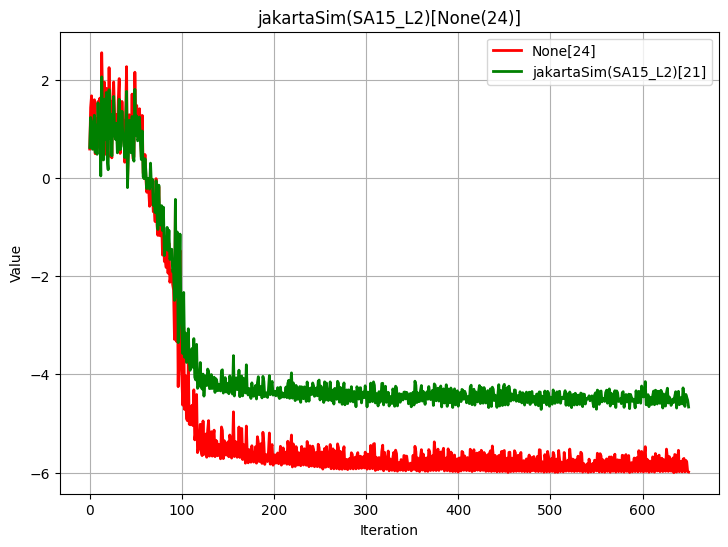

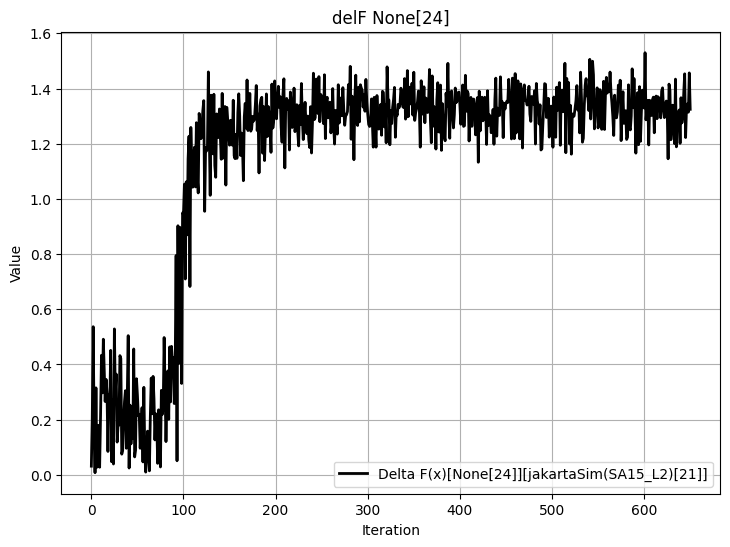

Duration 9 min, 42 sec Shots=None Iterations=200 Accepted=100.0 % Rejected=0 min at n=146
Expected -6.0 Ground State: Computed -4.665365 Min -4.714844 
Error 22.243924 % Minimum 21.419271 %


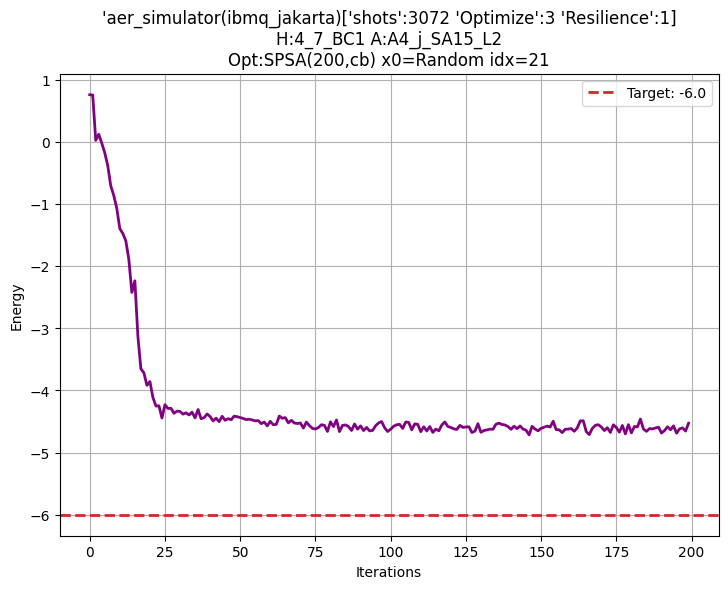

In [39]:
# kagome.list_results(curCache)
# kagome.plot_SPSA_callback(curCache[171])
if 0: # 2048
    compare_runs(curCache,indices=(7,3),labels=('None','jakartaSim(SA15_L2)'))
    compare_runs(curCache,indices=(8,4),labels=('None','jakartaSim(SA15_L2)'))
    compare_runs(curCache,indices=(9,5),labels=('None','jakartaSim(SA15_L2)'))
if 0: # 1024
    compare_runs(curCache,indices=(13,10),labels=('None','jakartaSim(SA15_L2)'))
    compare_runs(curCache,indices=(14,11),labels=('None','jakartaSim(SA15_L2)'))
    compare_runs(curCache,indices=(15,12),labels=('None','jakartaSim(SA15_L2)'))
if 1:  # 3072
#     compare_runs(curCache,indices=(22,19),labels=('None','jakartaSim(SA15_L2)'))
#     compare_runs(curCache,indices=(23,20),labels=('None','jakartaSim(SA15_L2)'))
    compare_runs(curCache,indices=(24,21),labels=('None','jakartaSim(SA15_L2)'))

# ============== 3072 Shots ================
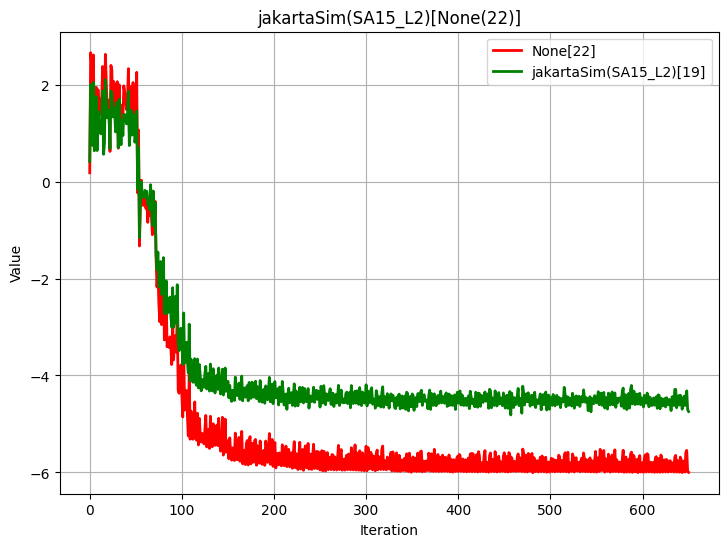
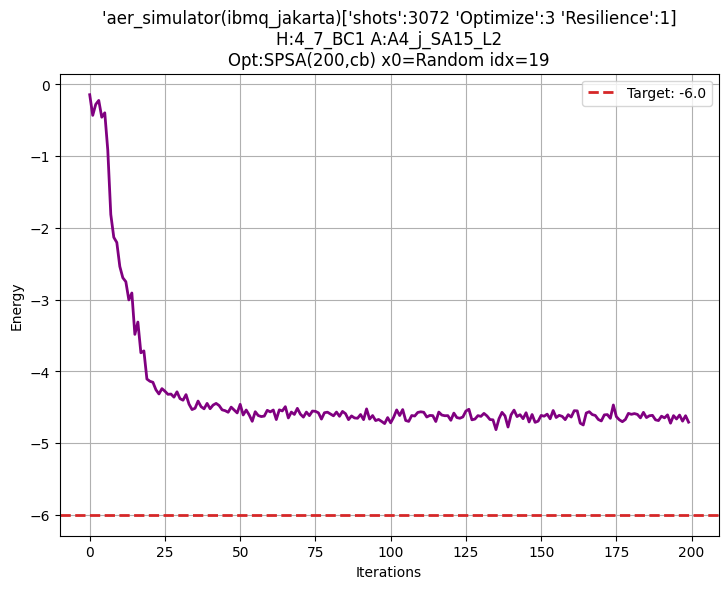
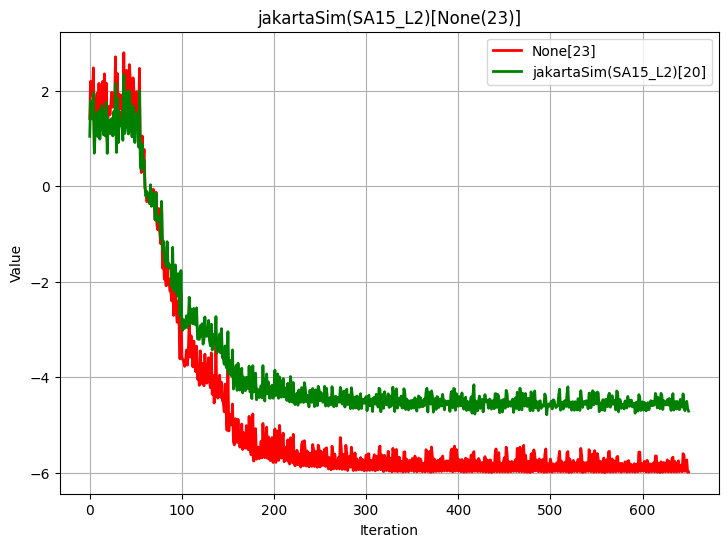
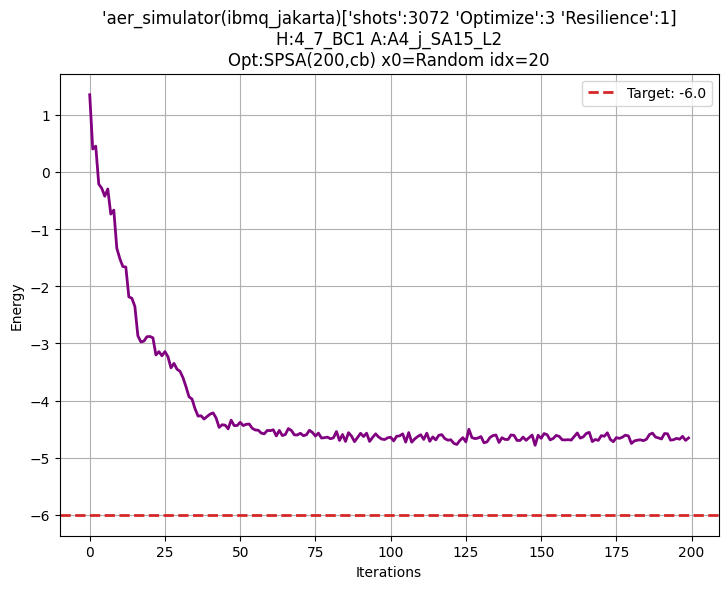
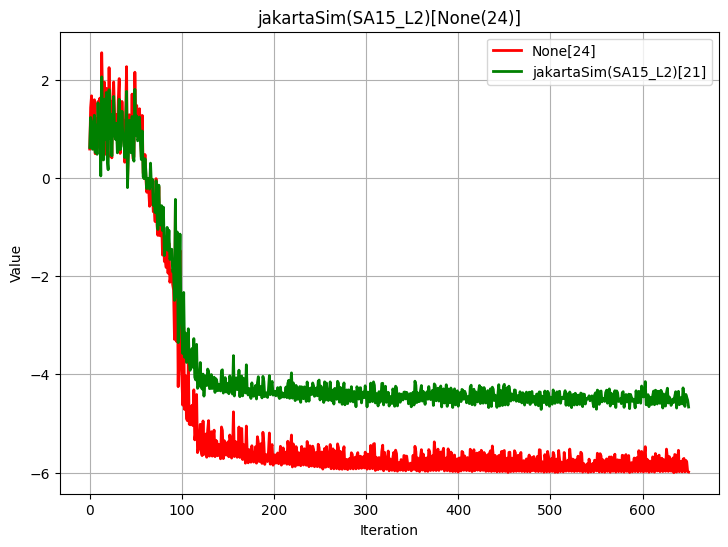
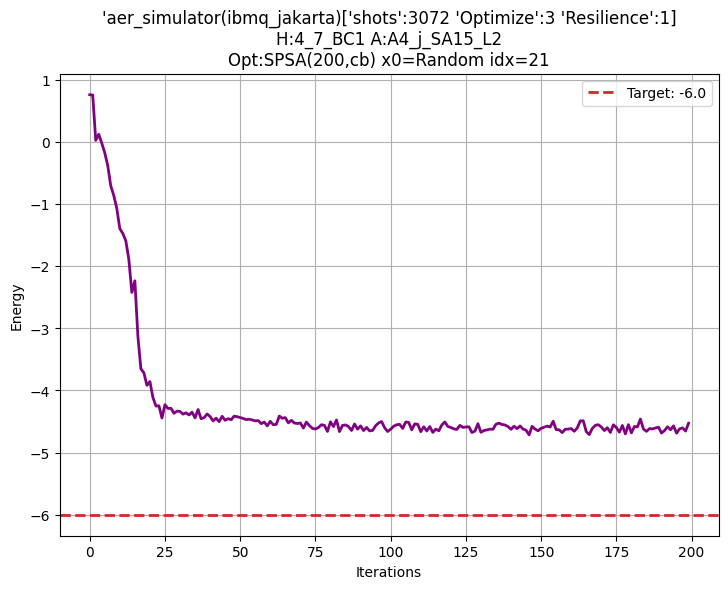

# ============== 1024 Shots ================
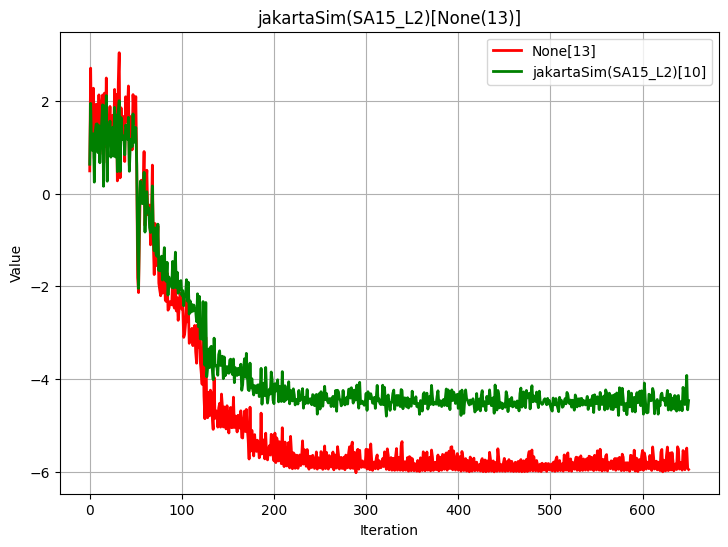
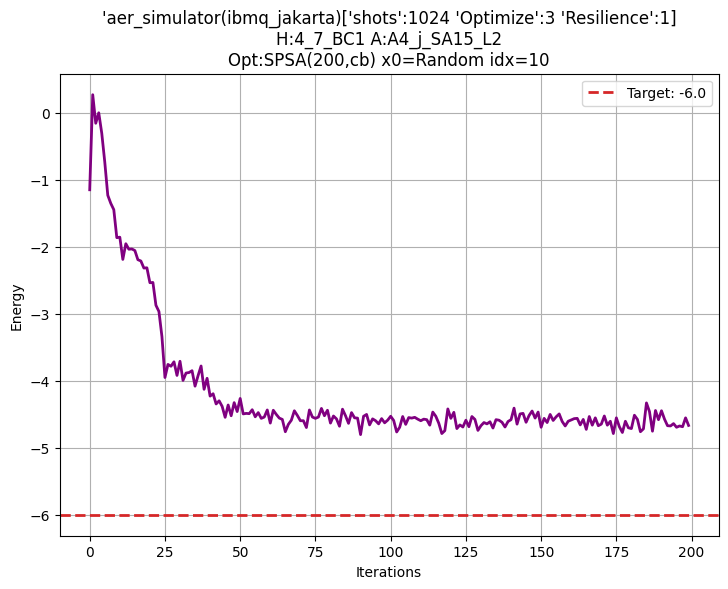
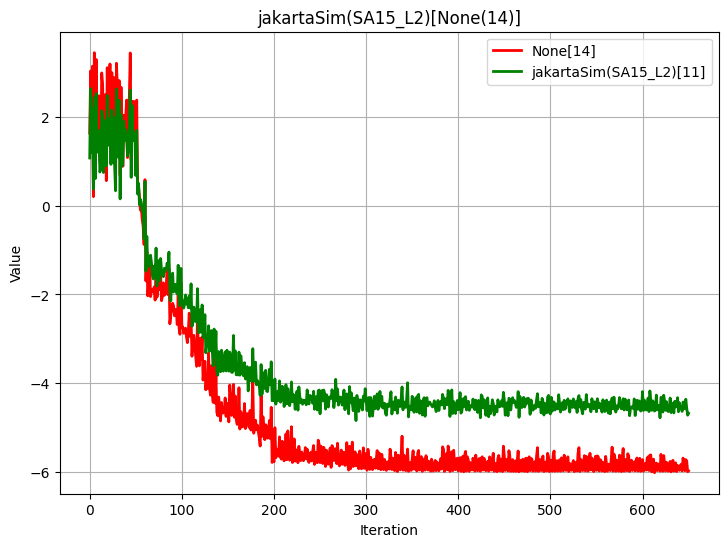
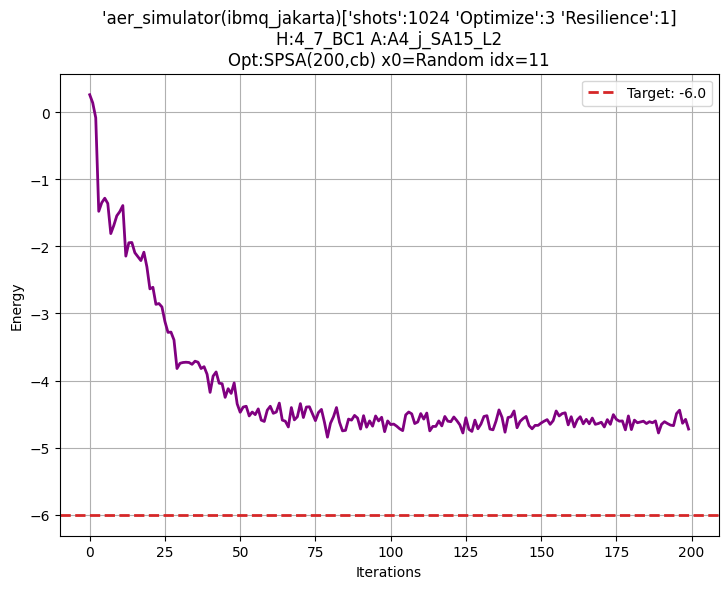
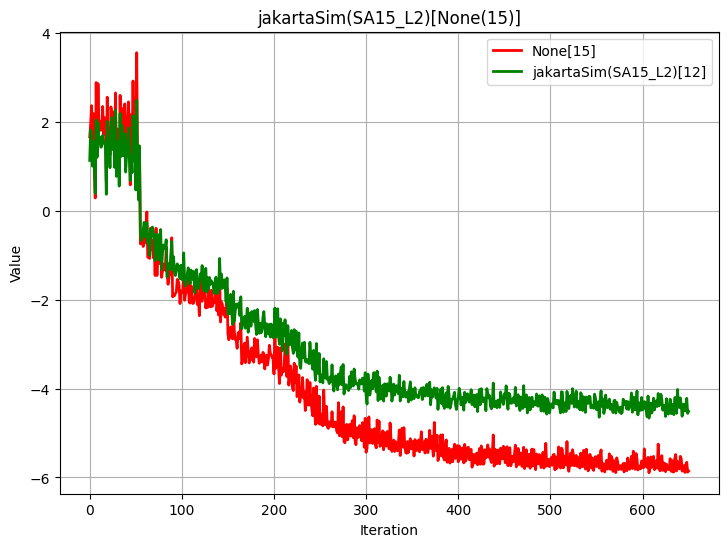
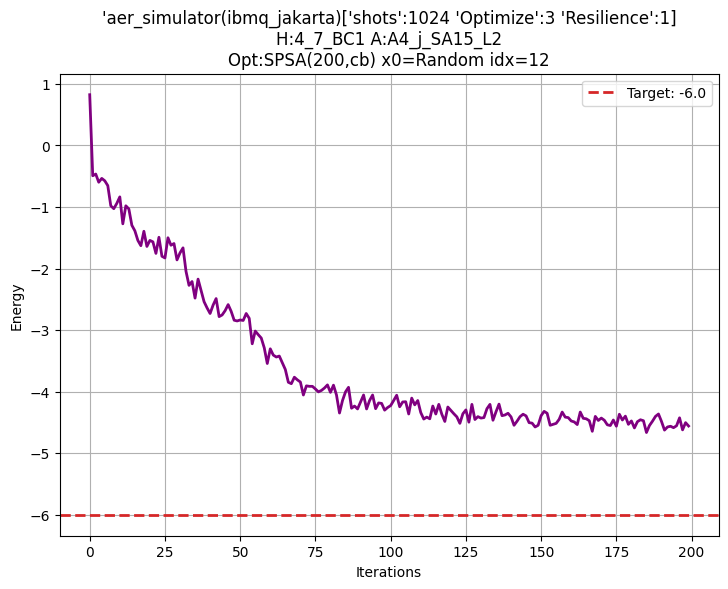


# ============== 2048 Shots ================
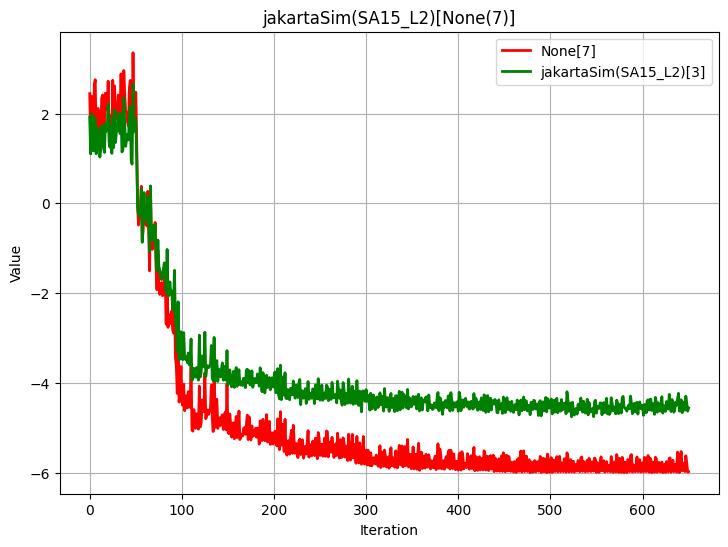
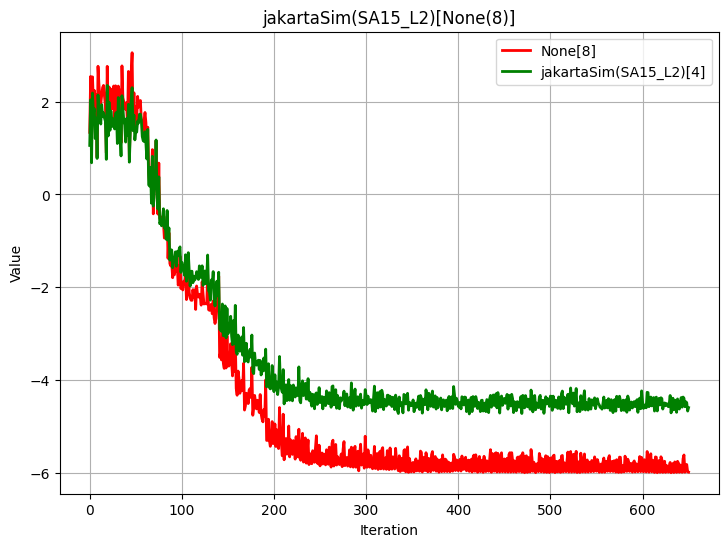
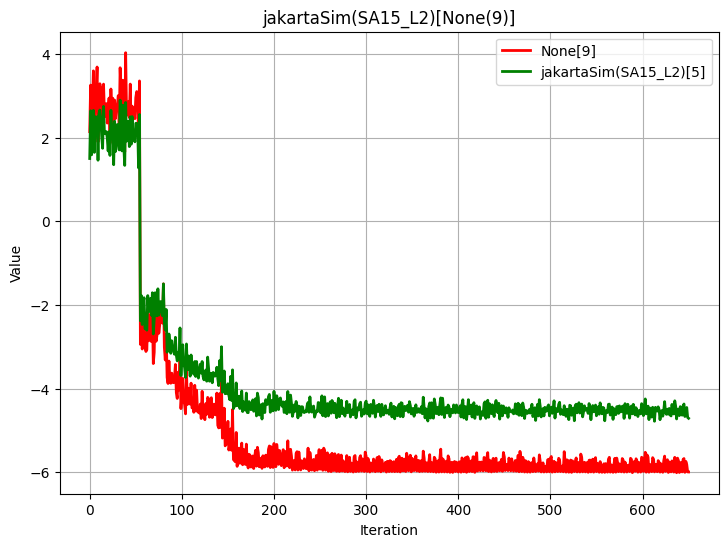


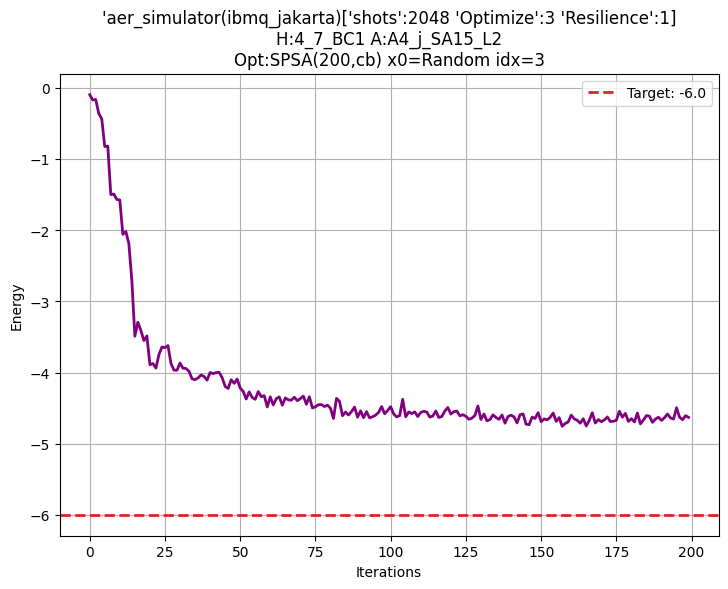
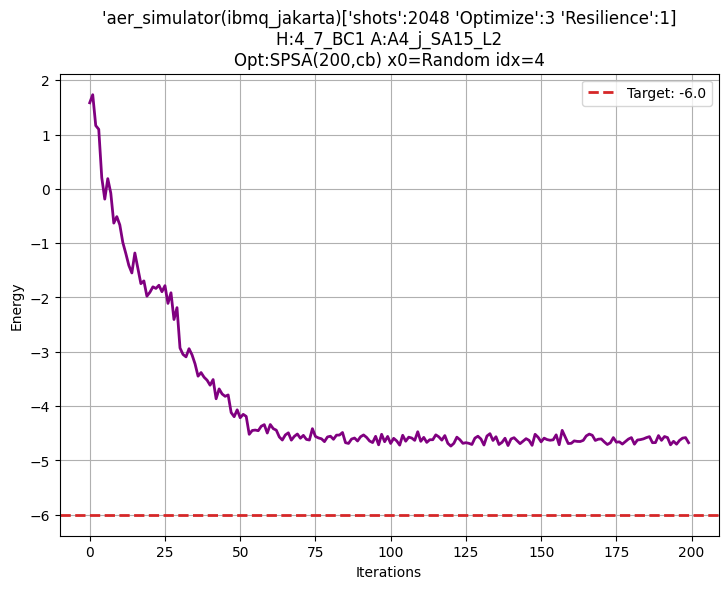
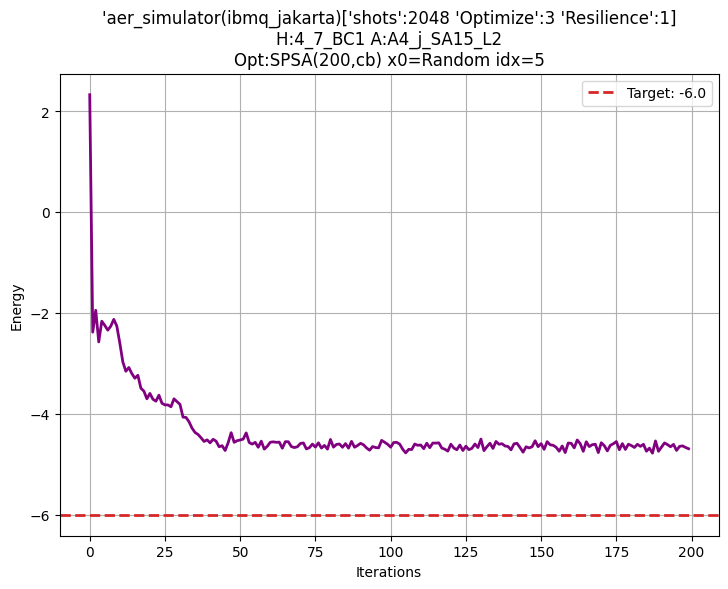

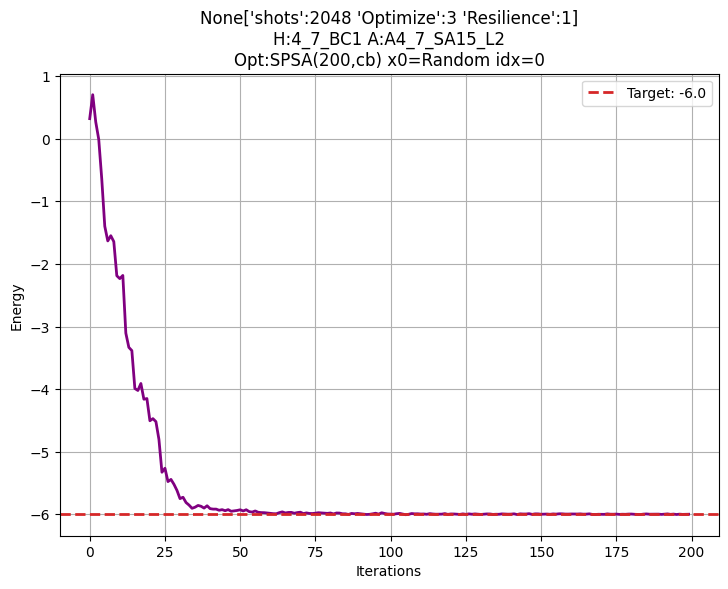
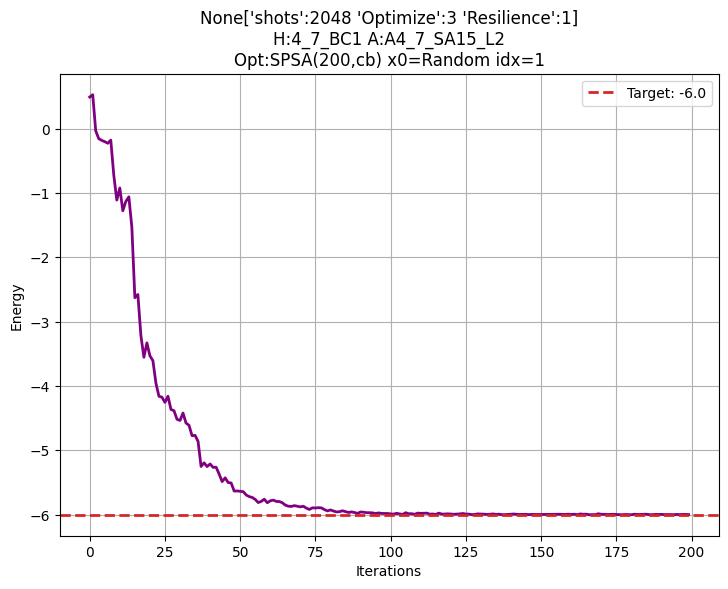
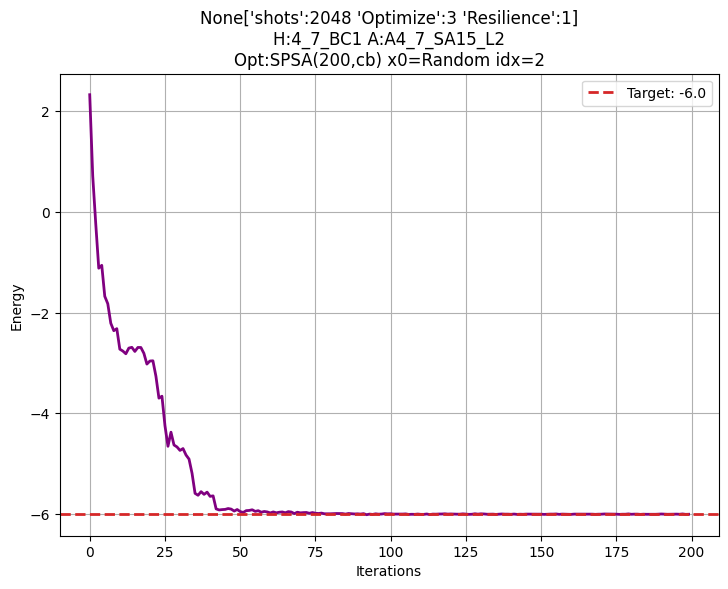


# Previous Images


# ==  Rejects


# ---------------------------------------------------------------------------------------------
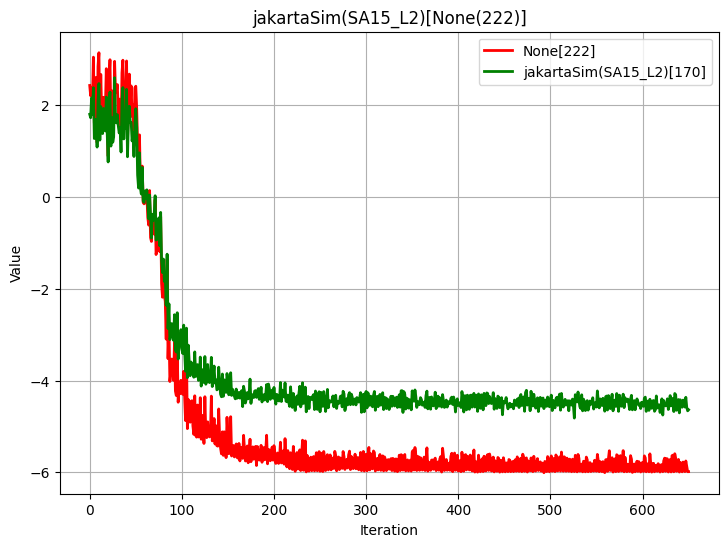
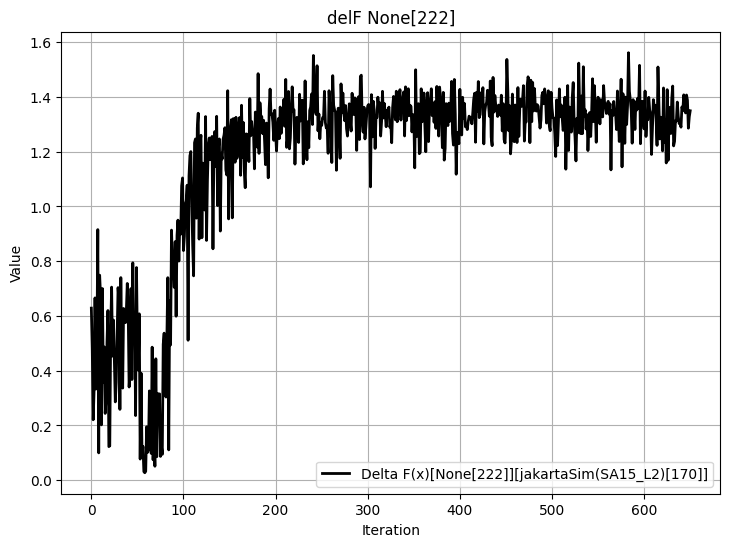
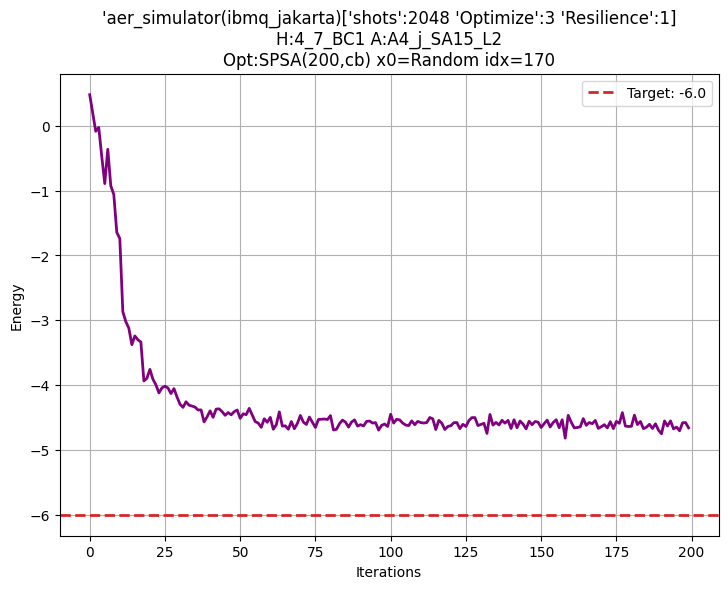

In [ ]:
# jobList2 = kagome.load_object('data/jobList.dump')
# jobList2
# list(jobResults2.keys())
# jobResults2 = kagome.load_object('data/jobResults.dump')
# jobResults2['cafae8aa-52c2-4f88-b6a0-ebc743f791c1']


def check_jobQ(jobQ,fname='data/jobResults.dump'):
    from qiskit.providers.jobstatus import JobStatus
    jobResults2 = kagome.load_object('data/jobResults.dump')
    for curJob in jobQ:
        if ( curJob.status() is JobStatus.DONE):
            if jobResults2.get(curJob.job_id(),None) is None:
                print(f"Adding results for {curJob.job_id()}")
                jobResults2[curJob.job_id()] = curJob.result()
                kagome.save_object(jobResults2,'data/jobResults.dump')
        else:
            print(f"Waiting on results for {curJob.job_id()}")
            

# check_jobQ(jobQ)


In [ ]:
def getBlochCoords(state_vector,qubit,num_qubits=None):
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi,r])
    return angles

def getCoords(state_vector, num_qubits=None):
    coords = []
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit,num_qubits=num_qubits))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi


def compare_edge_results(resultsA,resultsB,edges,A=None,x=None):
    from qiskit.quantum_info import Statevector
    from qiskit.visualization import plot_bloch_multivector

    delExp = resultsA.values - resultsB.values
    delTot = np.sum(delExp)
    percDelE = 100*delExp/delTot
    
    edgeDel = []
    print(f"\nexpA  = {np.sum(resultsA.values):14.10f}"
          f"\nexpB  = {np.sum(resultsB.values):14.10f}"
          f"\nDelta = {delTot:14.10f}")
    
    print("\nEdges")
    (i,edgesA,edgesB)=(0,[],[])
    for idx0 in range(0,len(resultsA.values),3):
        curEdgeA = resultsA.values[idx0]+resultsA.values[idx0+1]+resultsA.values[idx0+2]
        edgesA.append(curEdgeA)
        curEdgeB = resultsB.values[idx0]+resultsB.values[idx0+1]+resultsB.values[idx0+2]
        edgesB.append(curEdgeB)
        print(f"\t{edges[i][0]},{edges[i][1]}: A:{curEdgeA:14.10f}  B:{curEdgeB:14.10f} ")
        i+=1
      
    print("\nEdge Deltas")
    i=0
    for idx0 in range(0,len(delExp),3):
        curEdge = delExp[idx0]+delExp[idx0+1]+delExp[idx0+2]
        edgeDel.append(curEdge)
        print(f"\t{edges[i][0]},{edges[i][1]}: {curEdge:14.10f}")
        i+=1

    print(f"\nResultsA\tResultsB\tA-B\t% Diff\n"
          f"{resultsA.values}\n{resultsB.values}\n{delExp}"
          f"\n{percDelE}\n")
    if A is not None and x is not None:
        print(f"{A.name} at x")
        qc = A.bind_parameters(x)
        svector = Statevector(qc)
        print(f"(r,theta,phi):")       
        angles = getBlochAngles(svector)
        for idx in range(len(angles)) :
            curCoord = angles[idx]
            print(f"\t{idx}: ({curCoord[2]:9.6f},{curCoord[0]:9.6f},{curCoord[1]:9.6f} )")
        return plot_bloch_multivector(svector)

In [ ]:
qc = Anzs[Akey].bind_parameters(Xa)
qc.draw()
from qiskit.quantum_info import Statevector
svectorZ=Statevector(qc)
svectorZ.draw('latex')
qcX = qc.copy()
_= qcX.h([0,1,2,3,4])
svectorX = Statevector(qcX)
qcY = qc.copy()
_= qcY.sdg([0,1,2,3,4])
_= qcY.h([0,1,2,3,4])
svectorY = Statevector(qcY)

from qiskit.visualization import plot_state_qsphere
plot_state_qsphere(svectorX)
plot_state_qsphere(svectorY)
plot_state_qsphere(svectorZ)


# Additional Python Code to Include

In [ ]:
from typing import Optional, List, Union
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import array_to_latex

def num_to_latex_ket(raw_value: complex, first_term: bool, decimals: int = 10) -> Optional[str]:
    """Convert a complex number to latex code suitable for a ket expression

    Args:
        raw_value: Value to convert
        first_term: If True then generate latex code for the first term in an expression
        decimals: Number of decimal places to round to (default: 10).
    Returns:
        String with latex code or None if no term is required
    """
    import sympy  # runtime import

    if raw_value == 0:
        value = 0
        real_value = 0
        imag_value = 0
    else:
        raw_value = np.around(raw_value, decimals=decimals)
        value = sympy.nsimplify(raw_value, constants=(sympy.pi,), rational=False)
        real_value = float(sympy.re(value))
        imag_value = float(sympy.im(value))

    element = ""
    if np.abs(value) > 0:
        latex_element = sympy.latex(value, full_prec=False)
        two_term = real_value != 0 and imag_value != 0
        if isinstance(value, sympy.core.Add):
            # can happen for expressions like 1 + sqrt(2)
            two_term = True
        if two_term:
            if first_term:
                element = f"({latex_element})"
            else:
                element = f"+ ({latex_element})"
        else:
            if first_term:
                if np.isreal(complex(value)) and value > 0:
                    element = latex_element
                else:
                    element = latex_element
                if element == "1":
                    element = ""
                elif element == "-1":
                    element = "-"
            else:

                if imag_value == 0 and real_value > 0:
                    element = "+" + latex_element
                elif real_value == 0 and imag_value > 0:
                    element = "+" + latex_element
                else:
                    element = latex_element
                if element == "+1":
                    element = "+"
                elif element == "-1":
                    element = "-"

        return element
    else:
        return None

def numbers_to_latex_terms(numbers: List[complex], decimals: int = 10) -> List[str]:
    """Convert a list of numbers to latex formatted terms

    The first non-zero term is treated differently. For this term a leading + is suppressed.

    Args:
        numbers: List of numbers to format
        decimals: Number of decimal places to round to (default: 10).
    Returns:
        List of formatted terms
    """
    first_term = True
    terms = []
    for number in numbers:
        term = num_to_latex_ket(number, first_term, decimals)
        if term is not None:
            first_term = False
        terms.append(term)
    return terms


def _state_to_latex_ket(data: List[complex], max_size: int = 12, prefix: str = "") -> str:
    """Convert state vector to latex representation

    Args:
        data: State vector
        max_size: Maximum number of non-zero terms in the expression. If the number of
                 non-zero terms is larger than the max_size, then the representation is truncated.
        prefix: Latex string to be prepended to the latex, intended for labels.

    Returns:
        String with LaTeX representation of the state vector
    """
    num = int(np.log2(len(data)))

    def ket_name(i):
        return bin(i)[2:].zfill(num)

    data = np.around(data, max_size)
    nonzero_indices = np.where(data != 0)[0].tolist()
    if len(nonzero_indices) > max_size:
        nonzero_indices = (
            nonzero_indices[: max_size // 2] + [0] + nonzero_indices[-max_size // 2 + 1 :]
        )
        latex_terms = numbers_to_latex_terms(data[nonzero_indices], max_size)
        nonzero_indices[max_size // 2] = None
    else:
        latex_terms = numbers_to_latex_terms(data[nonzero_indices], max_size)

    latex_str = ""
    for idx, ket_idx in enumerate(nonzero_indices):
        if ket_idx is None:
            latex_str += r" + \ldots "
        else:
            term = latex_terms[idx]
            ket = ket_name(ket_idx)
            latex_str += f"{term} |{ket}\\rangle\\\\"  # added \n
    return prefix + latex_str

def state_to_latex(
    state: Union[Statevector, DensityMatrix], dims: bool = None, convention: str = "ket", **args
) -> str:
    """Return a Latex representation of a state. Wrapper function
    for `qiskit.visualization.array_to_latex` for convention 'vector'.
    Adds dims if necessary.
    Intended for use within `state_drawer`.

    Args:
        state: State to be drawn
        dims (bool): Whether to display the state's `dims`
        convention (str): Either 'vector' or 'ket'. For 'ket' plot the state in the ket-notation.
                Otherwise plot as a vector
        **args: Arguments to be passed directly to `array_to_latex` for convention 'ket'

    Returns:
        Latex representation of the state
    """
    if dims is None:  # show dims if state is not only qubits
        if set(state.dims()) == {2}:
            dims = False
        else:
            dims = True

    prefix = ""
    suffix = ""
    if dims:
        prefix = "\\begin{align}\n"
        dims_str = state._op_shape.dims_l()
        suffix = f"\\\\\n\\text{{dims={dims_str}}}\n\\end{{align}}"

    operator_shape = state._op_shape
    # we only use the ket convetion for qubit statevectors
    # this means the operator shape should hve no input dimensions and all output dimensions equal to 2
    is_qubit_statevector = len(operator_shape.dims_r()) == 0 and set(operator_shape.dims_l()) == {2}
    if convention == "ket" and is_qubit_statevector:
        latex_str = _state_to_latex_ket(state._data, **args)
    else:
        latex_str = array_to_latex(state._data, source=True, **args)
    return prefix + latex_str + suffix

def svector_draw_latex(state,**drawer_args):
    from IPython.display import Latex

    return Latex(f"$${state_to_latex(state, **drawer_args)}$$")


In [ ]:
from qiskit.quantum_info import SparsePauliOp
num_qubits=8
opQCs = {
         'X0': SparsePauliOp.from_sparse_list([("X", [0], 1), ], num_qubits=num_qubits),
         'X4': SparsePauliOp.from_sparse_list([("X", [4], 1), ], num_qubits=num_qubits),
         'Y0': SparsePauliOp.from_sparse_list([("Y", [0], 1), ], num_qubits=num_qubits),
         'Y4': SparsePauliOp.from_sparse_list([("Y", [4], 1), ], num_qubits=num_qubits),
         'Z0': SparsePauliOp.from_sparse_list([("Z", [0], 1), ], num_qubits=num_qubits),
         'Z4': SparsePauliOp.from_sparse_list([("Z", [4], 1), ], num_qubits=num_qubits),
         'X1': SparsePauliOp.from_sparse_list([("X", [1], 1), ], num_qubits=num_qubits),
         'Y1': SparsePauliOp.from_sparse_list([("Y", [1], 1), ], num_qubits=num_qubits),
         'Z1': SparsePauliOp.from_sparse_list([("Z", [1], 1), ], num_qubits=num_qubits),
         'X04': SparsePauliOp.from_sparse_list([("XX", [0,4], 1), ], num_qubits=num_qubits),
         'X01': SparsePauliOp.from_sparse_list([("XX", [0,1], 1), ], num_qubits=num_qubits),
         'Y04': SparsePauliOp.from_sparse_list([("YY", [0,4], 1), ], num_qubits=num_qubits),
         'Y01': SparsePauliOp.from_sparse_list([("YY", [0,1], 1), ], num_qubits=num_qubits),
         'Z04': SparsePauliOp.from_sparse_list([("ZZ", [0,4], 1), ], num_qubits=num_qubits),
         'Z01': SparsePauliOp.from_sparse_list([("ZZ", [0,1], 1), ], num_qubits=num_qubits),
        }

svector4  = Statevector(qcInit)
svector4a = Statevector(qcInit)
svector8a = svector4.expand(svector4a)

svector8 = Statevector(qc8)
# svector12 = Statevector(qc12)
print(f"================= svector4 ===============")
svector_draw_latex(svector4,max_size=24)
print()
print(f"================= svector8 ===============")
svector_draw_latex(svector8,max_size=24)
print(f"================= svector8a ===============")
svector_draw_latex(svector8a,max_size=24)


for key, curOp in opQCs.items():
#     opVals[key] = Statevector(qc12).expectation_value(curOp)
#     print(f"exp_val.qc12({key}:{curOp.paulis})= {opVals[key]:.11f}")
    opVals[key] = Statevector(qc8).expectation_value(curOp)
    print(f"exp_val.qc08({key}:{curOp.paulis})= "
          f"{Statevector(qc8).expectation_value(curOp):.11f}")
    print(f"exp_val.qc08a({key}:{curOp.paulis})= "
          f"{svector8a.expectation_value(curOp):.11f}")

In [ ]:
num_qubits=8
edgeValues={}
xactions = [ [0,1], [0,2], [2,1], [1,3], [0,1], [0,3] ]  # 4_BC1
# xactions = [ [0,1], [0,2], [2,1], [1,3], [1,4], [3,4] ]  # 4_BC1
# xactions = [ [0,4], [1,0], [3,0],[1,4], [3,4] ]
# xactions = [ [4,5], [4,6], [6,5], [5,7], [4,5], [4,7] ]  # 4_BC1
for curXaction in xactions:
    key=f"{curXaction[0]}-{curXaction[1]}"
    while edgeValues.get(key,None) is not None:
        key += 'a'
    _=hamiltonians.BoundaryCondition(curXaction,None,num_qubits)
    edgeValues[key] = Statevector(qc8).expectation_value(
                        hamiltonians.BoundaryCondition(curXaction,None,num_qubits))
total = 0
for key,value in edgeValues.items():
    total += value
    print(f"{key}: {np.around(np.real(value),6)}")
print(f"\nTotal: {np.real(total):.6f}")

# Boundary Conditions

## Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}
